In [1]:
# Install required packages
!pip install tensorflow numpy matplotlib seaborn scikit-learn opencv-python-headless -q

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import cv2
from IPython.display import display, Markdown

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
BASE_PATH = "/content/drive/MyDrive/chest_xray"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30  # Increased epochs
AUTOTUNE = tf.data.AUTOTUNE

# Gaussian blur implementation
def gaussian_blur(image, kernel_size=3, sigma=1.0):
    """Apply Gaussian blur using TensorFlow operations"""
    kernel = tf.range(-kernel_size//2 + 1, kernel_size//2 + 1, dtype=tf.float32)
    kernel = tf.exp(-(kernel**2) / (2 * sigma**2))
    kernel = kernel / tf.reduce_sum(kernel)
    kernel = tf.tensordot(kernel, kernel, axes=0)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]
    kernel = tf.tile(kernel, [1, 1, 3, 1])

    blurred = tf.nn.depthwise_conv2d(
        image[tf.newaxis, ...],
        kernel,
        strides=[1, 1, 1, 1],
        padding="SAME"
    )
    return blurred[0]

# 1. Enhanced Dataset Handling ------------------------------------------------

def load_dataset(path):
    """Load dataset with quality filtering"""
    classes = ["NORMAL", "PNEUMONIA"]
    file_paths = []
    labels = []

    for cls in classes:
        cls_path = os.path.join(path, cls)
        for file in os.listdir(cls_path):
            if file.endswith(".jpeg"):
                file_path = os.path.join(cls_path, file)

                # Basic quality check
                img = cv2.imread(file_path)
                if img is None or img.size == 0:
                    continue  # Skip corrupt images

                # Contrast check (skip low contrast images)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                contrast = gray.std()
                if contrast < 25:  # Skip low contrast images
                    continue

                file_paths.append(file_path)
                labels.append(1 if cls == "PNEUMONIA" else 0)

    return file_paths, labels

# Load datasets
train_paths, train_labels = load_dataset(os.path.join(BASE_PATH, "train"))
test_paths, test_labels = load_dataset(os.path.join(BASE_PATH, "test"))

# Handle validation set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

# 2. Enhanced Data Preprocessing ----------------------------------------------

def preprocess_image(path, label):
    """Enhanced preprocessing with better augmentation"""
    # Read and decode image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Convert grayscale to RGB
    img = tf.cond(tf.shape(img)[-1] == 1,
                  lambda: tf.repeat(img, repeats=3, axis=-1),
                  lambda: img)

    # Resize and normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = applications.efficientnet.preprocess_input(img)

    # Enhanced augmentation
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_left_right(img)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_up_down(img)

    img = tf.image.random_brightness(img, max_delta=0.15)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.random_hue(img, max_delta=0.02)

    # Apply Gaussian blur to 30% of images
    if tf.random.uniform(()) > 0.7:
        img = gaussian_blur(img)

    return img, label

def create_dataset(paths, labels, is_training=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()

    if is_training:
        dataset = dataset.shuffle(buffer_size=1500)
        dataset = dataset.repeat()

    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(buffer_size=AUTOTUNE)

# Create datasets
train_ds = create_dataset(train_paths, train_labels, is_training=True)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

# Handle class imbalance
pneumonia_count = np.sum(train_labels)
normal_count = len(train_labels) - pneumonia_count
total = len(train_labels)

weight_for_0 = (1 / normal_count) * (total / 2.0)
weight_for_1 = (1 / pneumonia_count) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0 (Normal): {weight_for_0:.2f}")
print(f"Weight for class 1 (Pneumonia): {weight_for_1:.2f}")

Training samples: 2725
Validation samples: 682
Test samples: 636
Weight for class 0 (Normal): 2.02
Weight for class 1 (Pneumonia): 0.66


In [2]:
# 3. Improved Model Architecture ----------------------------------------------

def build_model():
    """Enhanced model with regularization"""
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling="avg"
    )

    # Freeze more layers
    base_model.trainable = True
    for layer in base_model.layers[:180]:
        layer.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=True)

    # Enhanced classification head with regularization
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Increased dropout

    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(name="prc", curve="PR")  # Precision-Recall curve
        ]
    )
    return model

model = build_model()
model.summary()

# 4. Enhanced Training with More Callbacks ------------------------------------

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_prc",  # Monitor Precision-Recall AUC
    patience=8,
    mode="max",
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,  # More aggressive reduction
    patience=3,
    min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_prc",
    mode="max"
)

# Calculate steps per epoch
steps_per_epoch = len(train_paths) // BATCH_SIZE

# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Load best model
model = keras.models.load_model("best_model.h5")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412,068 (16.83 MB)

 Trainable params: 3,031,489 (11.56 MB)

 Non-trainable params: 1,380,579 (5.27 MB)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6556 - auc: 0.7760 - loss: 1.2130 - prc: 0.9106 - precision: 0.8907 - recall: 0.6232

85/85 ━━━━━━━━━━━━━━━━━━━━ 117s 543ms/step - accuracy: 0.6566 - auc: 0.7771 - loss: 1.2115 - prc: 0.9111 - precision: 0.8912 - recall: 0.6240 - val_accuracy: 0.8475 - val_auc: 0.9690 - val_loss: 1.0647 - val_prc: 0.9902 - val_precision: 0.9904 - val_recall: 0.8051 - learning_rate: 1.0000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8358 - auc: 0.9523 - loss: 0.9202 - prc: 0.9815 - precision: 0.9787 - recall: 0.8002

85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8360 - auc: 0.9524 - loss: 0.9199 - prc: 0.9815 - precision: 0.9787 - recall: 0.8005 - val_accuracy: 0.9018 - val_auc: 0.9825 - val_loss: 0.9244 - val_prc: 0.9946 - val_precision: 0.9934 - val_recall: 0.8752 - learning_rate: 1.0000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8722 - auc: 0.9703 - loss: 0.8579 - prc: 0.9908 - precision: 0.9813 - recall: 0.8516

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8724 - auc: 0.9703 - loss: 0.8576 - prc: 0.9908 - precision: 0.9812 - recall: 0.8517 - val_accuracy: 0.9252 - val_auc: 0.9855 - val_loss: 0.8553 - val_prc: 0.9956 - val_precision: 0.9978 - val_recall: 0.9025 - learning_rate: 1.0000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8998 - auc: 0.9798 - loss: 0.7981 - prc: 0.9930 - precision: 0.9804 - recall: 0.8842

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9000 - auc: 0.9798 - loss: 0.7979 - prc: 0.9930 - precision: 0.9804 - recall: 0.8844 - val_accuracy: 0.9267 - val_auc: 0.9865 - val_loss: 0.8599 - val_prc: 0.9961 - val_precision: 0.9978 - val_recall: 0.9045 - learning_rate: 1.0000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9422 - auc: 0.9914 - loss: 0.7231 - prc: 0.9971 - precision: 0.9885 - recall: 0.9343

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9421 - auc: 0.9914 - loss: 0.7232 - prc: 0.9971 - precision: 0.9885 - recall: 0.9343 - val_accuracy: 0.9413 - val_auc: 0.9875 - val_loss: 0.7854 - val_prc: 0.9963 - val_precision: 0.9917 - val_recall: 0.9298 - learning_rate: 1.0000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9519 - auc: 0.9921 - loss: 0.7039 - prc: 0.9971 - precision: 0.9903 - recall: 0.9456

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9518 - auc: 0.9921 - loss: 0.7040 - prc: 0.9971 - precision: 0.9902 - recall: 0.9456 - val_accuracy: 0.9501 - val_auc: 0.9904 - val_loss: 0.7554 - val_prc: 0.9971 - val_precision: 0.9938 - val_recall: 0.9396 - learning_rate: 1.0000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9557 - auc: 0.9916 - loss: 0.6991 - prc: 0.9970 - precision: 0.9914 - recall: 0.9494

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9557 - auc: 0.9917 - loss: 0.6988 - prc: 0.9970 - precision: 0.9914 - recall: 0.9494 - val_accuracy: 0.9501 - val_auc: 0.9912 - val_loss: 0.7126 - val_prc: 0.9972 - val_precision: 0.9858 - val_recall: 0.9474 - learning_rate: 1.0000e-04
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9665 - auc: 0.9954 - loss: 0.6630 - prc: 0.9985 - precision: 0.9932 - recall: 0.9624

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9665 - auc: 0.9954 - loss: 0.6630 - prc: 0.9985 - precision: 0.9932 - recall: 0.9623 - val_accuracy: 0.9560 - val_auc: 0.9929 - val_loss: 0.7134 - val_prc: 0.9977 - val_precision: 0.9959 - val_recall: 0.9454 - learning_rate: 1.0000e-04
Epoch 9/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9599 - auc: 0.9942 - loss: 0.6679 - prc: 0.9982 - precision: 0.9909 - recall: 0.9563 - val_accuracy: 0.9428 - val_auc: 0.9891 - val_loss: 0.7078 - val_prc: 0.9966 - val_precision: 0.9778 - val_recall: 0.9454 - learning_rate: 1.0000e-04
Epoch 10/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9606 - auc: 0.9943 - loss: 0.6636 - prc: 0.9982 - precision: 0.9924 - recall: 0.9551

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9607 - auc: 0.9943 - loss: 0.6633 - prc: 0.9982 - precision: 0.9924 - recall: 0.9552 - val_accuracy: 0.9619 - val_auc: 0.9928 - val_loss: 0.6970 - val_prc: 0.9978 - val_precision: 0.9939 - val_recall: 0.9552 - learning_rate: 1.0000e-04
Epoch 11/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9702 - auc: 0.9979 - loss: 0.6307 - prc: 0.9994 - precision: 0.9974 - recall: 0.9640 - val_accuracy: 0.9604 - val_auc: 0.9899 - val_loss: 0.7257 - val_prc: 0.9971 - val_precision: 0.9980 - val_recall: 0.9493 - learning_rate: 1.0000e-04
Epoch 12/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9730 - auc: 0.9967 - loss: 0.6277 - prc: 0.9990 - precision: 0.9965 - recall: 0.9685 - val_accuracy: 0.9575 - val_auc: 0.9911 - val_loss: 0.7098 - val_prc: 0.9973 - val_precision: 0.9919 - val_recall: 0.9513 - learning_rate: 1.0000e-04
Epoch 13/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9815 - auc: 0.9981 - loss: 0.5990 - prc:

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9814 - auc: 0.9981 - loss: 0.5991 - prc: 0.9994 - precision: 0.9962 - recall: 0.9789 - val_accuracy: 0.9707 - val_auc: 0.9945 - val_loss: 0.6374 - val_prc: 0.9982 - val_precision: 0.9901 - val_recall: 0.9708 - learning_rate: 1.0000e-04
Epoch 14/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9793 - auc: 0.9964 - loss: 0.6135 - prc: 0.9989 - precision: 0.9946 - recall: 0.9779 - val_accuracy: 0.9545 - val_auc: 0.9917 - val_loss: 0.7065 - val_prc: 0.9975 - val_precision: 0.9979 - val_recall: 0.9415 - learning_rate: 1.0000e-04
Epoch 15/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9776 - auc: 0.9967 - loss: 0.6018 - prc: 0.9991 - precision: 0.9957 - recall: 0.9748

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9777 - auc: 0.9968 - loss: 0.6018 - prc: 0.9991 - precision: 0.9957 - recall: 0.9748 - val_accuracy: 0.9692 - val_auc: 0.9948 - val_loss: 0.6281 - val_prc: 0.9984 - val_precision: 0.9900 - val_recall: 0.9688 - learning_rate: 1.0000e-04
Epoch 16/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9860 - auc: 0.9995 - loss: 0.5705 - prc: 0.9998 - precision: 0.9990 - recall: 0.9824 - val_accuracy: 0.9633 - val_auc: 0.9934 - val_loss: 0.6522 - val_prc: 0.9980 - val_precision: 0.9939 - val_recall: 0.9571 - learning_rate: 1.0000e-04
Epoch 17/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9792 - auc: 0.9985 - loss: 0.5778 - prc: 0.9995 - precision: 0.9978 - recall: 0.9746 - val_accuracy: 0.9707 - val_auc: 0.9921 - val_loss: 0.6233 - val_prc: 0.9974 - val_precision: 0.9862 - val_recall: 0.9747 - learning_rate: 1.0000e-04
Epoch 18/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9870 - auc: 0.9973 - loss: 0.5748 - prc:

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9875 - auc: 0.9995 - loss: 0.5399 - prc: 0.9998 - precision: 0.9958 - recall: 0.9874 - val_accuracy: 0.9692 - val_auc: 0.9957 - val_loss: 0.5892 - val_prc: 0.9986 - val_precision: 0.9824 - val_recall: 0.9766 - learning_rate: 1.0000e-04
Epoch 21/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9852 - auc: 0.9998 - loss: 0.5323 - prc: 0.9999 - precision: 0.9976 - recall: 0.9831 - val_accuracy: 0.9604 - val_auc: 0.9947 - val_loss: 0.6142 - val_prc: 0.9985 - val_precision: 0.9959 - val_recall: 0.9513 - learning_rate: 1.0000e-04
Epoch 22/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9909 - auc: 0.9996 - loss: 0.5262 - prc: 0.9999 - precision: 0.9955 - recall: 0.9923 - val_accuracy: 0.9663 - val_auc: 0.9950 - val_loss: 0.5919 - val_prc: 0.9986 - val_precision: 0.9940 - val_recall: 0.9610 - learning_rate: 1.0000e-04
Epoch 23/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9907 - auc: 0.9989 - loss: 0.5240 - prc:

In [3]:
model.save("xray_classification.keras")

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 654ms/step - accuracy: 0.6430 - auc: 0.6224 - loss: 1.3715 - prc: 0.5810 - precision: 0.3870 - recall: 0.6585


## Test Results
- **Accuracy**: 0.8003
- **Precision**: 0.7625
- **Recall**: 0.9900
- **AUC**: 0.9335
- **PR AUC**: 0.9516

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step

Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

      NORMAL       0.97      0.48      0.64       237
   PNEUMONIA       0.76      0.99      0.86       399

    accuracy                           0.80       636
   macro avg       0.86      0.74      0.75       636
weighted avg       0.84      0.80      0.78       636


Optimal Threshold: 0.8768 (F1=0.9091)

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      NORMAL       0.92      0.73      0.82       237
   PNEUMONIA       0.86      0.96      0.91       399

    accuracy                           0.88       636
   macro avg       0.89      0.85      0.86       636
weighted avg       0.88      0.88      0.87       636



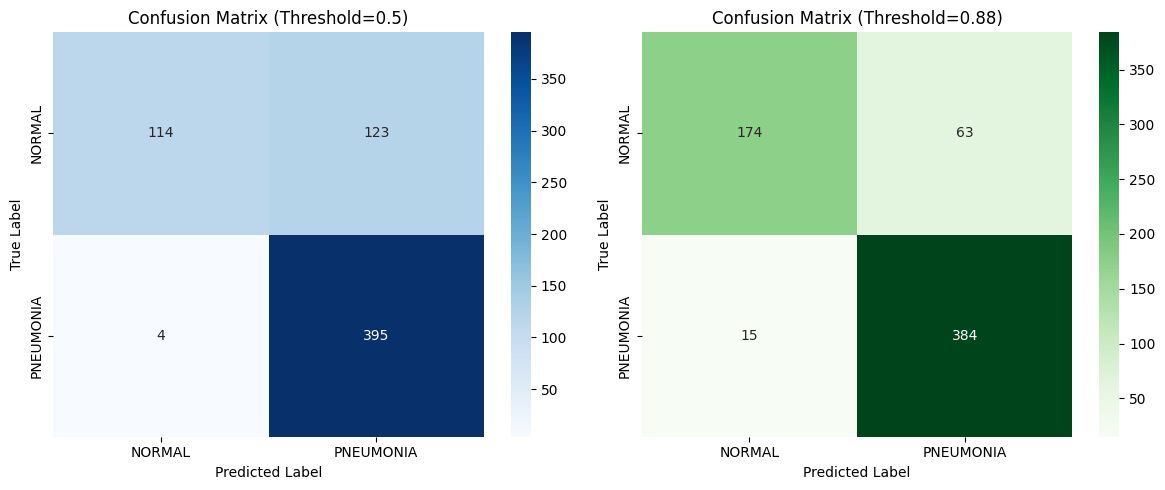

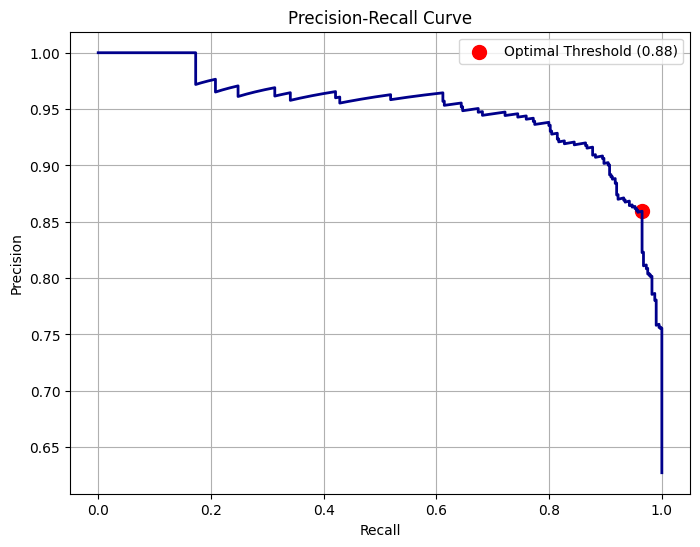

In [ ]:
# 5. Enhanced Evaluation ------------------------------------------------------

# Evaluate on test set
test_results = model.evaluate(test_ds)
display(Markdown(f"## Test Results\n"
                 f"- **Accuracy**: {test_results[1]:.4f}\n"
                 f"- **Precision**: {test_results[2]:.4f}\n"
                 f"- **Recall**: {test_results[3]:.4f}\n"
                 f"- **AUC**: {test_results[4]:.4f}\n"
                 f"- **PR AUC**: {test_results[5]:.4f}"))

# Predictions
y_true = test_labels
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print("\nClassification Report (Threshold=0.5):")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Find optimal threshold using Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f} (F1={f1_scores[optimal_idx]:.4f})")

# Classification Report with Optimal Threshold
y_pred_optimal = (y_pred_probs > optimal_threshold).astype(int)
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_default = confusion_matrix(y_true, y_pred)
sns.heatmap(cm_default, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.title("Confusion Matrix (Threshold=0.5)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.subplot(1, 2, 2)
cm_optimal = confusion_matrix(y_true, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt="d", cmap="Greens",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.title(f"Confusion Matrix (Threshold={optimal_threshold:.2f})")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkblue', lw=2)
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', s=100,
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()